<a href="https://colab.research.google.com/github/Jade-P/MLGroupProject/blob/Neutral--Jade/Neutral_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Data exploration

I manually removed images that did not contain a face, expressed the wrong emotion, or contained more than one face. Below are some examples of images that I removed.

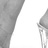

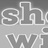

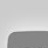

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pwd

'/content'

In [3]:
cd '/content/drive/MyDrive/ECS171/emotionDataSet'

/content/drive/.shortcut-targets-by-id/1Z5iKjOa4METq6Gspzm97KWYkNG2sG5Wo/ECS171/emotionDataSet


In [4]:
pwd

'/content/drive/.shortcut-targets-by-id/1Z5iKjOa4METq6Gspzm97KWYkNG2sG5Wo/ECS171/emotionDataSet'

##**Loading Data** 

In [14]:
import numpy as np 
from tqdm import tqdm # for progress bar
import pandas as pd
import cv2
import os
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
init_notebook_mode(connected=True)
RANDOM_SEED = 123

In [6]:
TRAIN_DIR = ('Training/Training/')
TEST_DIR = ('Testing/Testing/')

In [7]:
emotions = ['Angry', 'Fear', 'Happy', 'Neutral', 'Sad', 'Suprise']

In [8]:
def load_data(dir_path, IMG_SIZE):
   
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(emotions)):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    #print(img.shape)
                    img = img.astype('float32') / 255
                    resized = cv2.resize(img, IMG_SIZE, interpolation = cv2.INTER_AREA)
                    X.append(resized)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [9]:
IMG_SIZE= (48, 48)

In [10]:
X_train, y_train, train_labels = load_data(TRAIN_DIR, IMG_SIZE)

100%|██████████| 6/6 [10:45<00:00, 107.62s/it]


28572 images loaded from Training/Training/ directory.


In [11]:
train_labels

{0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Neutral', 4: 'Sad', 5: 'Suprise'}

In [12]:
X_test, y_test, test_labels = load_data(TEST_DIR,IMG_SIZE)

100%|██████████| 6/6 [02:52<00:00, 28.81s/it]

7129 images loaded from Testing/Testing/ directory.


Size of Images (Or the structures)

Standardization check

##Data preprocessing

Removing Duplicates _Sohyun

In [16]:
import cv2  
from skimage.metrics import structural_similarity

image_list = []

path = TRAIN_DIR + '/Neutral' #QUESTION - IS THIS ALL I HAVE TO CHANGE?

for f in os.listdir(path):
  image_list.append(f)

img_size = list(map(lambda x: os.path.getsize(path + '/' + x), image_list))

# Find Same Photos
img_data = pd.DataFrame({'filename':image_list, 'size':img_size})

print('number of images :', len(img_data))

number of images : 5242


In [17]:
# Photo Value Counts
filename_cnts = pd.DataFrame({'filename':img_data['filename'].value_counts().index, 'fn_counts':img_data['filename'].value_counts().values})   
imgsize_cnts = pd.DataFrame({'size':img_data['size'].value_counts().index, 'size_counts':img_data['size'].value_counts().values})   

img_data = pd.merge(img_data, filename_cnts, how = 'left', on = 'filename')
img_data = pd.merge(img_data, imgsize_cnts, how = 'left', on = 'size')

img_data.sample(2)

,filename,size,fn_counts,size_counts
1531,Neutral-996.jpg,1910,1,4
3313,Neutral-1783.jpg,1643,1,17


In [18]:
SimilarSizeData = imgsize_cnts[imgsize_cnts['size_counts'] > 1]

Use structural similarity to compare similarity of images

In [19]:
def CompareImage(imageA, imageB):

    # Grayscale
    grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)
    
    # Check Image structure
    if len(grayA)==len(grayB):
        (score, diff) = structural_similarity(grayA, grayB, full=True)

    return score

In [20]:
delete = dict()

In [21]:
for i in range(len(SimilarSizeData)):

    temp = img_data[img_data['size']==SimilarSizeData['size'][i]].reset_index(drop = True).sort_values(['filename'])

    candidates = []

    for j in range(len(temp) - 1):
      filenameA = temp['filename'][j]
      compared = False

      for key in delete:
        if (filenameA in delete[key]):
          compared = True
          break
      
      if compared:
        continue

      for k in range(j+1, len(temp)):
        filenameB = temp['filename'][k]
        
        imageA = cv2.imread(path+'/'+filenameA)
        imageB = cv2.imread(path+'/'+filenameB)

        score = CompareImage(imageA, imageB)
        
        if (score == 1 or score > 0.6):
          if filenameA not in delete:
            delete[filenameA] = [filenameB]
          else:
            delete[filenameA].append(filenameB)
          if (score < 1):
            print(filenameA + ", " + filenameB)
            print("score: " + str(score))
          

In [23]:
total = [len(value) for key, value in delete.items()]
print(str(sum(total)) + " duplicates found")

381 duplicates found


Plotting some duplicates to confirm they are the same

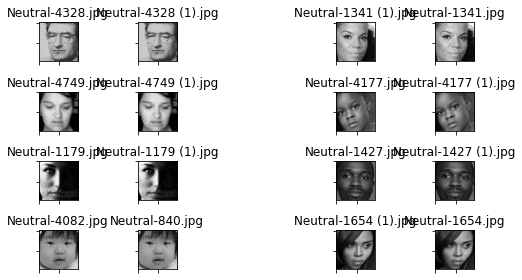

In [24]:
plt.figure(0, figsize=(8,4))
cpt = 0

n = 8

for key in delete:
  if (n == 0):
    break

  cpt += 1
  ax = plt.subplot(4,6,cpt)
  ax.set_title(key)
  img = cv2.imread(path+"/"+ key)
  plt.tick_params(labelleft=False,labelbottom=False)
  plt.imshow(img,cmap="gray")

  for file in delete[key]:
    cpt += 1
    ax = plt.subplot(4,6,cpt)
    ax.set_title(file)

    img = cv2.imread(path+"/"+ file)
    plt.tick_params(labelleft=False,labelbottom=False)
    plt.imshow(img,cmap="gray")
    pass
  
  if (cpt % 3 != 0):
    cpt +=1
  n -= 1

plt.tight_layout()
plt.show()

In [25]:
orig_list = image_list

print("original image number: " + str(len(orig_list)))

original image number: 5242


In [26]:
for key in delete:
  for val in delete[key]:
    image_list.remove(val)

print("updated images number: " + str(len(image_list)))

updated images number: 4861


In [27]:
pwd

'/content/drive/.shortcut-targets-by-id/1Z5iKjOa4METq6Gspzm97KWYkNG2sG5Wo/ECS171/emotionDataSet'

In [31]:
os.chdir(os.getcwd() + '/' + TRAIN_DIR + 'Neutral')

Remove images

In [32]:
for key in delete:
  print("Removing duplicates of " + key)
  for val in delete[key]:
    print(val + " removed")
    os.remove(val)

Removing duplicates of Neutral-4328.jpg
Neutral-4328 (1).jpg removed
Removing duplicates of Neutral-1341 (1).jpg
Neutral-1341.jpg removed
Removing duplicates of Neutral-4749.jpg
Neutral-4749 (1).jpg removed
Removing duplicates of Neutral-4177.jpg
Neutral-4177 (1).jpg removed
Removing duplicates of Neutral-1179.jpg
Neutral-1179 (1).jpg removed
Removing duplicates of Neutral-1427.jpg
Neutral-1427 (1).jpg removed
Removing duplicates of Neutral-4082.jpg
Neutral-840.jpg removed
Removing duplicates of Neutral-1654 (1).jpg
Neutral-1654.jpg removed
Removing duplicates of Neutral-3916 (1).jpg
Neutral-3916.jpg removed
Removing duplicates of Neutral-3585.jpg
Neutral-3585 (1).jpg removed
Removing duplicates of Neutral-2285.jpg
Neutral-2933.jpg removed
Removing duplicates of Neutral-1545.jpg
Neutral-1545 (1).jpg removed
Removing duplicates of Neutral-4617.jpg
Neutral-4617 (1).jpg removed
Removing duplicates of Neutral-2717 (1).jpg
Neutral-2717.jpg removed
Removing duplicates of Neutral-3586.jpg
Neu

Data Augmentation? (Shifting, Rotating, Brightness, Cropping ...)

**Standardization Check**

https://machinelearningmastery.com/how-to-normalize-center-and-standardize-images-with-the-imagedatagenerator-in-keras/

Standardization assumes that the distribution of the data is Gaussian, which we cannot guarantee, so instead of standardization we should use scaling. The scaling will be done at training time after we set up a generator and iterator as shown below:

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
# create generator (1.0/255.0 = 0.003921568627451)
datagen = ImageDataGenerator(rescale=1.0/255.0)
# prepare an iterators to scale images
train_iterator = datagen.flow(X_train, y_train, batch_size=64)
test_iterator = datagen.flow(X_test, y_test, batch_size=64)
print('Batches train=%d, test=%d' % (len(train_iterator), len(test_iterator)))
# confirm the scaling works
batchX, batchy = train_iterator.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

**Resizing**

When we build the model, we will add a resizing layer using keras.layers.Resizing to resize the images to 48*48.